In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip



Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "chest_xray/train"
val_path = "chest_xray/val"
test_path = "chest_xray/test"

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(150,150), batch_size=32, class_mode='binary')
val_data = val_gen.flow_from_directory(val_path, target_size=(150,150), batch_size=32, class_mode='binary')
test_data = test_gen.flow_from_directory(test_path, target_size=(150,150), batch_size=32, class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, epochs=5, validation_data=val_data)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.8359 - loss: 0.4593 - val_accuracy: 0.8750 - val_loss: 0.3133
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9735 - loss: 0.0673 - val_accuracy: 0.8750 - val_loss: 0.2004
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9807 - loss: 0.0592 - val_accuracy: 0.7500 - val_loss: 0.3239
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9853 - loss: 0.0404 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9858 - loss: 0.0386 - val_accuracy: 0.8750 - val_loss: 0.4713


In [5]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.6927 - loss: 2.4895
Test Accuracy: 70.19%


In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np


img_path = 'chest_xray/chest_xray/train/NORMAL/IM-0719-0001.jpeg'
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img) / 255.
img_tensor = np.expand_dims(img_tensor, axis=0)

prediction = model.predict(img_tensor)
print("Pneumonia" if prediction[0][0] > 0.5 else "Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Normal


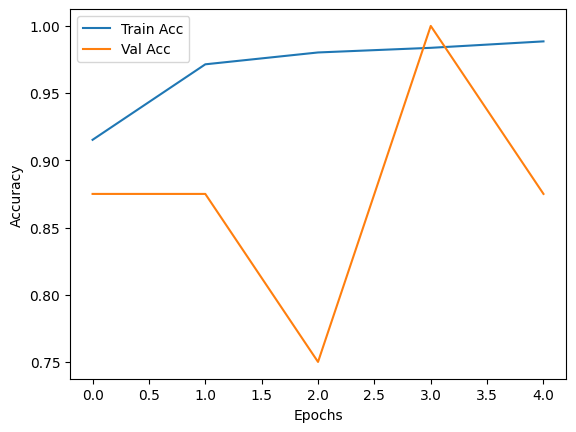

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [31]:
model.save("pneumonia_model.keras")
